In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import SMAXLogWrapper
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
import time
import os
import matplotlib.pyplot as plt

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
#import qdax.tasks.brax.v1 as environments
#from qdax.tasks.brax.v1.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics


## Brax version conflict with JaxMARL(0.10.3) and QDax(0.10.4 / 0.12.3)

In [2]:
from typing import Callable, Optional, Tuple
from qdax.custom_types import (
    Descriptor,
    EnvState,
    ExtraScores,
    Fitness,
    Genotype,
    Observation,
    Params,
    RNGKey,
)

In [3]:
batch_size = 64# 128 # Num of offsprings 
#env_name = 'walker2d_uni'
episode_length = 128  # NUM_STEPS
num_iterations = 610  # TOTAL_TIMESTEPS / (NUM_ENVS × NUM_STEPS)
seed = 88 
policy_hidden_layer_sizes = (128, 128, 128) #(64, 64)
iso_sigma = 0.1 #0.005 
line_sigma = 0.8 #0.05 
num_init_cvt_samples = 20000 #50000 
num_centroids = 2000 #1024 
min_descriptor = 0. 
max_descriptor = 1.0 

config = {
        "LR": 0.004,
        "NUM_ENVS": 128,
        "NUM_STEPS": 128,
        "GRU_HIDDEN_DIM": 128,
        "FC_DIM_SIZE": 128,
        "TOTAL_TIMESTEPS": 1e7,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.05,
        "SCALE_CLIP_EPS": False,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.25,
        "ACTIVATION": "relu",
        "ENV_NAME": "HeuristicEnemySMAX",
        "MAP_NAME": "2s3z",
        "SEED": 88,
        "ENV_KWARGS": {
            "see_enemy_actions": True,
            "walls_cause_death": True,
            "attack_mode": "closest"
        },
        "ANNEAL_LR": True,
    }

In [4]:
class ScannedRNN(nn.Module):
    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        rnn_state = carry
        ins, resets = x
        resets = jnp.atleast_1d(resets)
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(*rnn_state.shape),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=ins.shape[1])(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (batch_size, hidden_size))


class ActorRNN(nn.Module):
    action_dim: int
    config: Dict

    @nn.compact
    def __call__(self, hidden, x):
        obs, dones, avail_actions = x  # [T, B, obs_dim], [T, B], [T, B, action_dim]

        # Embed observation
        embedding = nn.Dense(
            self.config["FC_DIM_SIZE"],
            kernel_init=orthogonal(np.sqrt(2)),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        # RNN
        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        # Actor head
        actor_logits = nn.Dense(self.config["GRU_HIDDEN_DIM"],
                                kernel_init=orthogonal(2),
                                bias_init=constant(0.0))(embedding)
        actor_logits = nn.relu(actor_logits)
        actor_logits = nn.Dense(self.action_dim,
                                kernel_init=orthogonal(0.01),
                                bias_init=constant(0.0))(actor_logits)

        # Mask out unavailable actions
        unavail_actions = 1 - avail_actions
        masked_logits = actor_logits - (unavail_actions * 1e10)

        # Return distribution (or raw logits if QDax expects them)
        pi = distrax.Categorical(logits=masked_logits)

        return hidden, pi

In [5]:
def linear_schedule(count):
    frac = (
        1.0
        - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
        / config["NUM_UPDATES"]
    )
    return config["LR"] * frac

In [6]:
# Init environment
#env = environments.create(env_name, episode_length=episode_length)
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
reset_fn = jax.jit(env.reset)
config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)

# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_space(env.agents[0]).n,)
policy_network = ActorRNN(env.action_space(env.agents[0]).n, config=config)

# Init population of controllers
key, subkey = jax.random.split(key)
#keys = jax.random.split(subkey, num=batch_size)
# fake_batch = jnp.zeros(shape=(batch_size, env.observation_size)) # Not needed as on-policy is used for no batches?
# init_variables = jax.vmap(policy_network.init)(keys, fake_batch)
init_x = (
    jnp.zeros(
        (1, config["NUM_ENVS"], env.observation_space(env.agents[0]).shape[0])
    ),
    jnp.zeros((1, config["NUM_ENVS"])),
    jnp.zeros((1, config["NUM_ENVS"], env.action_space(env.agents[0]).n)),
)
init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], config["GRU_HIDDEN_DIM"])

keys = jax.random.split(subkey, batch_size)
# Assume init_hstate: [H], init_x: [X]
fake_hstate = jnp.stack([init_hstate] * batch_size)  # [N, H]
#fake_x = jnp.stack([init_x] * config["NUM_ENVS"])            # [N, X]
fake_x = tuple(jnp.stack([x] * batch_size) for x in init_x)
#network_params = policy_network.init(subkey, init_hstate, init_x)
network_params = jax.vmap(
    policy_network.init
)(keys, fake_hstate, fake_x)


In [7]:
class Transition(NamedTuple):
    global_done: jnp.ndarray
    done: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    obs: jnp.ndarray
    env_state: jnp.ndarray
    info: jnp.ndarray
    avail_actions: jnp.ndarray

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

In [8]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    runner_state
):
    """
    Play an environment step and return the updated state and the transition.
    """
    policies_params, env_state, last_obs, last_done, hstate, rng = runner_state
    
    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    avail_actions = jax.vmap(env.get_avail_actions)(env_state.env_state)
    avail_actions = jax.lax.stop_gradient(
        batchify(avail_actions, env.agents, config["NUM_ACTORS"])
    )
    obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
    ac_in = (
        obs_batch[np.newaxis, :],
        last_done[np.newaxis, :],
        avail_actions,
    )
    hstate, pi = policy_network.apply(policies_params, hstate, ac_in)
    # For evaluation choose action greedily (one with highest probability)
    #action = pi.sample(seed=_rng)
    action = pi.mode()

    # STEP ENV
    env_act = unbatchify(
        action, env.agents, config["NUM_ENVS"], env.num_agents
    )
    env_act = {k: v.squeeze() for k, v in env_act.items()}
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, config["NUM_ENVS"])
    obsv, env_state, reward, done, info = jax.vmap(
        env.step, in_axes=(0, 0, 0)
    )(rng_step, env_state, env_act)
    info = jax.tree.map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
    done_batch = batchify(done, env.agents, config["NUM_ACTORS"]).squeeze()

    runner_state = (policies_params, env_state, obsv, done_batch, hstate, rng)
    #state_desc = env_state.info["state_descriptor"]
    #next_state = env.step(env_state, actions)

    transition = Transition(
        jnp.tile(done["__all__"], env.num_agents),
        last_done,
        action.squeeze(),
        batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
        obs_batch,
        env_state.env_state.state,
        info,
        avail_actions,
    )

    return runner_state, transition

In [9]:
def generate_unroll(
    runner_state,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey],
        Tuple[
            EnvState,
            Params,
            RNGKey,
            Transition,
        ],
    ],
) -> Tuple[EnvState, Transition]:
    """Generates an episode according to the agent's policy, returns the final state of
    the episode and the transitions of the episode.

    Args:
        init_state: first state of the rollout.
        policy_params: params of the individual.
        key: random key for stochasiticity handling.
        episode_length: length of the rollout.
        play_step_fn: function describing how a step need to be taken.

    Returns:
        A new state, the experienced transition.
    """

    def _scan_play_step_fn(
        carry, unused_arg: Any #: Tuple[EnvState, Params, RNGKey]
    ) -> Tuple[Tuple[EnvState, Params, RNGKey], Transition]:
        runner_state, transitions = play_step_fn(carry)
        return runner_state, transitions

    runner_state, transitions = jax.lax.scan(
        _scan_play_step_fn,
        runner_state,
        (),
        length=episode_length,
    )
    return runner_state, transitions


def get_mask_from_transitions(
    data: Transition,
) -> jnp.ndarray:
    is_done = jnp.clip(jnp.cumsum(data.global_done, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)
    return mask

In [10]:
def scoring_function(
    policies_params: Genotype,
    key: RNGKey,
    episode_length: int,
    play_reset_fn: Callable[[RNGKey], EnvState],
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores]:
    """Evaluates policies contained in policies_params in parallel.
    The play_reset_fn function allows for a more general scoring_function that can be
    called with different batch-size and not only with a batch-size of the same
    dimension as init_states.

    To define purely stochastic environments, using the reset function from the
    environment, use "play_reset_fn = env.reset".

    To define purely deterministic environments, as in "scoring_function", generate
    a single init_state using "init_state = env.reset(key)", then use
    "play_reset_fn = lambda key: init_state".

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        key: A jax random key
        episode_length: The maximal rollout length.
        play_reset_fn: The function to reset the environment and obtain initial states.
        play_step_fn: The function to play a step of the environment.
        descriptor_extractor: The function to extract the descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from the evaluation
    """

    # Reset environments
    key, subkey = jax.random.split(key)
    #keys = jax.random.split(subkey, jax.tree.leaves(policies_params)[0].shape[0])
    keys = jax.random.split(subkey, config["NUM_ENVS"])
    obsv, env_state = jax.vmap(play_reset_fn, in_axes=(0,))(keys)
    
    if config["ANNEAL_LR"]:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(learning_rate=linear_schedule, eps=1e-5),
        )
    else:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(config["LR"], eps=1e-5),
        )
    
    #train_state = TrainState.create(
    #        apply_fn=policy_network.apply,
    #        params=policies_params,
    #        tx=tx,
    #    )
    init_hstate = ScannedRNN.initialize_carry(config["NUM_ACTORS"], config["GRU_HIDDEN_DIM"])

    #done = jnp.zeros((batch_size, config["NUM_ACTORS"]), dtype=bool)
    
    keys = jax.random.split(key, batch_size)
    #init_runner_state = (
    #        train_state,
    #        env_state,
    #        obsv,
    #        jnp.zeros((config["NUM_ACTORS"]), dtype=bool), # done,
    #        init_hstate,
    #        subkey,
    #    )
    batched_env_state = jax.tree.map(lambda x: jnp.stack([x] * batch_size), env_state)
    batched_obsv = jax.tree.map(lambda x: jnp.stack([x] * batch_size), obsv)
    init_runner_state = (
        policies_params,#jax.tree.map(lambda x: jnp.stack([x] * config["NUM_ENVS"]), train_state),
        batched_env_state, #jnp.stack([env_state] * config["NUM_ENVS"]),
        batched_obsv, #jnp.stack([obsv] * config["NUM_ENVS"]),
        jnp.stack([jnp.zeros((config["NUM_ACTORS"]), dtype=bool)] * batch_size),
        jnp.stack([init_hstate] * batch_size),
        keys,  # already batched
    )

    # Step environments
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
    )
    #keys = jax.random.split(key, jax.tree.leaves(policies_params)[0].shape[0])
    _, data = jax.vmap(unroll_fn)(init_runner_state) # data = Transistions data struc

    # Create a mask to extract data properly
    mask = get_mask_from_transitions(data)

    # Evaluate
    print("data.reward shape:", data.reward.shape)
    #fitnesses = jnp.sum(data.reward * (1.0 - mask), axis=1)
    fitnesses = jnp.sum(data.reward * (1.0 - mask), axis=(1, 2))  # shape (32,)
    fitnesses = fitnesses.reshape(-1, 1)  # shape (32, 1)
    descriptors = descriptor_extractor(data, mask)

    print("fitness shape:", fitnesses.shape)
    print("descriptors shape:", descriptors.shape)

    return fitnesses, descriptors, {"transitions": data}


In [11]:
def compute_descriptors(data):
    """
    Compute per-trajectory descriptors:
    - % of units that moved last step (per batch item)
    - % of units that attacked last step (per batch item)
    - Avg ally-ally distance at final step (per batch item)
    
    Output: shape (batch_size, 3)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    attacked = attack_actions > 0                                    # (B, T, E, A)
    is_ally = (teams == 0).astype(jnp.float32)                        # (B, T, E, A)
    ally_alive = alive * is_ally                                      # (B, T, E, A)

    # Per batch movement/attack % (sum over all but batch dim)
    def pct_nonzero(mask, alive_mask):
        numerator = jnp.sum(mask * alive_mask, axis=(1, 2, 3))        # (B,)
        denominator = jnp.sum(alive_mask, axis=(1, 2, 3)) + 1e-8      # (B,)
        return numerator / denominator                                # (B,)

    movement_pct = pct_nonzero(moved, ally_alive)                    # (B,)
    attack_pct = pct_nonzero(attacked, ally_alive)                   # (B,)

    # Final step only for positions and masks
    final_positions = positions[:, -1, :, :, :]                      # (B, E, A, 2)
    final_alive = alive[:, -1, :, :]                                 # (B, E, A)
    final_teams = teams[:, -1, :, :]                                 # (B, E, A)
    ally_mask = (final_teams == 0) * final_alive                     # (B, E, A)

    def avg_pairwise_distance(pos, mask):
        """
        pos: (A, 2)
        mask: (A,)
        returns: scalar distance
        """
        diffs = pos[:, None, :] - pos[None, :, :]                    # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)                      # (A, A)
        pair_mask = mask[:, None] * mask[None, :]                    # (A, A)
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    # vmap over batch and envs: returns shape (B, E)
    avg_dists = jax.vmap(
        jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),
        in_axes=(0, 0)
    )(final_positions, ally_mask)

    avg_dist = jnp.mean(avg_dists, axis=1)  # mean over envs → shape (B,)

    # Normalize and clip
    max_distance = 32
    quarter_max = 0.25 * max_distance 
    norm_dist = avg_dist / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    # Stack all descriptors → shape (B, 3)
    return jnp.stack([movement_pct, attack_pct, norm_dist], axis=-1)


def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute final xy position.

    This function suppose that state descriptor is the xy position, as it
    just select the final one of the state descriptors given.
    """
    # reshape mask for descriptor extraction
    mask = jnp.expand_dims(mask, axis=-1)

    # Get descriptor
    #last_index = jnp.int32(jnp.sum(1.0 - mask, axis=1)) - 1
    #descriptors = jax.vmap(lambda x, y: x[y])(data.state_desc, last_index)
    descriptors = compute_descriptors(data)

    # remove the dim coming from the trajectory
    return descriptors#.squeeze(axis=1)


In [12]:
def compute_descriptors_old(data):
    """Compute useful descriptors from the state:
    - % of units that moved last step
    - Avg ally-ally distance
    - Avg enemy-enemy distance
    - Avg ally-enemy distance
    """
    #print("Got state of type:", type(state))
    #print("State attributes:", dir(state))  # See what's actually in it
    alive = data.env_state.unit_alive.astype(jnp.float32)           # [num_units]
    positions = data.env_state.unit_positions                       # [num_units, 2]
    teams = data.env_state.unit_teams                               # [num_units], e.g. 0 = ally, 1 = enemy
    movement_actions = data.env_state.prev_movement_actions
    attack_actions = data.env_state.prev_attack_actions
    
    print("movement_actions.shape:", movement_actions.shape)
    _, _, _, A, _ = movement_actions.shape

    print("movement_actions.shape:", movement_actions.shape)
    print("attack_actions.shape:", attack_actions.shape)
    print("alive.shape:", alive.shape)
    # Reshape actions from (128, 640) to (128, 10, 64)
    #discrete_actions = jnp.argmax(actions, axis=-1)  # (128, 10)
    
    movement_actions_mask = movement_actions != -1
    attack_actions_mask = attack_actions != -1
    
    ally_mask = ((teams == 0) & (alive == 1)).astype(jnp.float32)  # [num_units]
    enemy_mask = ((teams == 1) & (alive == 1)).astype(jnp.float32)
    
    movement_actions_mask = movement_actions_mask * ally_mask
    attack_actions_mask = attack_actions_mask * ally_mask

    # Define how many of the first N actions are "movement" actions
    #num_movement_actions = 5  # Change this if your setup differs

    # === Calculate percentages ===
    #total_valid = jnp.sum(combined_mask) + 1e-8  # avoid div by zero
    ally_total = jnp.sum(ally_mask) #+ 1e-8
    enemy_total = jnp.sum(enemy_mask) #+ 1e-8

    movement_pct = jnp.sum(movement_actions_mask) / ally_total
    attack_pct = jnp.sum(attack_actions_mask) / ally_total

    # Calualate avg distance between alled units
    # Expand for pairwise ops
    pos_i = positions[:, :, :, None, :]  # (T, B, A, 1, 2)
    pos_j = positions[:, :, None, :, :]  # (T, B, 1, A, 2)

    dist_matrix = jnp.linalg.norm(pos_i - pos_j, axis=-1)  # (T, B, A, A)

    # Mask to consider only alive allies pairs (i != j)
    mask_i = ally_mask[:, :, :, None]
    mask_j = ally_mask[:, :, None, :]
    pair_mask = mask_i * mask_j  # (T, B, A, A)

    # Remove self-distance (diagonal)
    not_self = 1 - jnp.eye(A)[None, None, :, :]  # (1, 1, A, A)
    pair_mask *= not_self

    # Sum of distances and count of valid pairs
    total_dist = jnp.sum(dist_matrix * pair_mask)
    num_pairs = jnp.sum(pair_mask)

    # Avoid division by zero
    avg_dist = total_dist / (num_pairs + 1e-8)
    
    def avg_pairwise_distance(mask):
        # Masked positions (zero for dead or others)
        masked_pos = positions * mask[:, None]
        diffs = masked_pos[:, None, :] - masked_pos[None, :, :]     # [N, N, 2]
        dists = jnp.linalg.norm(diffs, axis=-1)                     # [N, N]
        pair_mask = mask[:, None] * mask[None, :]                   # [N, N]
        total_dist = jnp.sum(dists * pair_mask)
        num_pairs = jnp.sum(pair_mask)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    def avg_cross_team_distance(mask1, mask2):
        pos1 = positions[mask1.astype(bool)]
        pos2 = positions[mask2.astype(bool)]
        if pos1.shape[0] == 0 or pos2.shape[0] == 0:
            return 0.0
        diffs = pos1[:, None, :] - pos2[None, :, :]       # [N1, N2, 2]
        dists = jnp.linalg.norm(diffs, axis=-1)
        return jnp.mean(dists)

    return jnp.array([
        movement_pct,
        attack_pct,
        avg_dist
    ])

In [14]:
# Prepare the scoring function
# descriptor_extraction_fn = environments.descriptor_extractor[env_name] # Need to write my own function to extract descriptors
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
#reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=1#reward_offset * episode_length, # Used to ensure QD score is positive could set to 1 if not needed
)

In [15]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

In [16]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=3,#env.descriptor_length, # Num of dimensions in the descriptor
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(network_params, centroids, subkey)

data.reward shape: (64, 128, 640)
fitness shape: (64, 1)
descriptors shape: (64, 3)


In [17]:
log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

data.reward shape: (64, 128, 640)
fitness shape: (64, 1)
descriptors shape: (64, 3)


NotImplementedError: Grid plot supports 2 descriptors only for now.

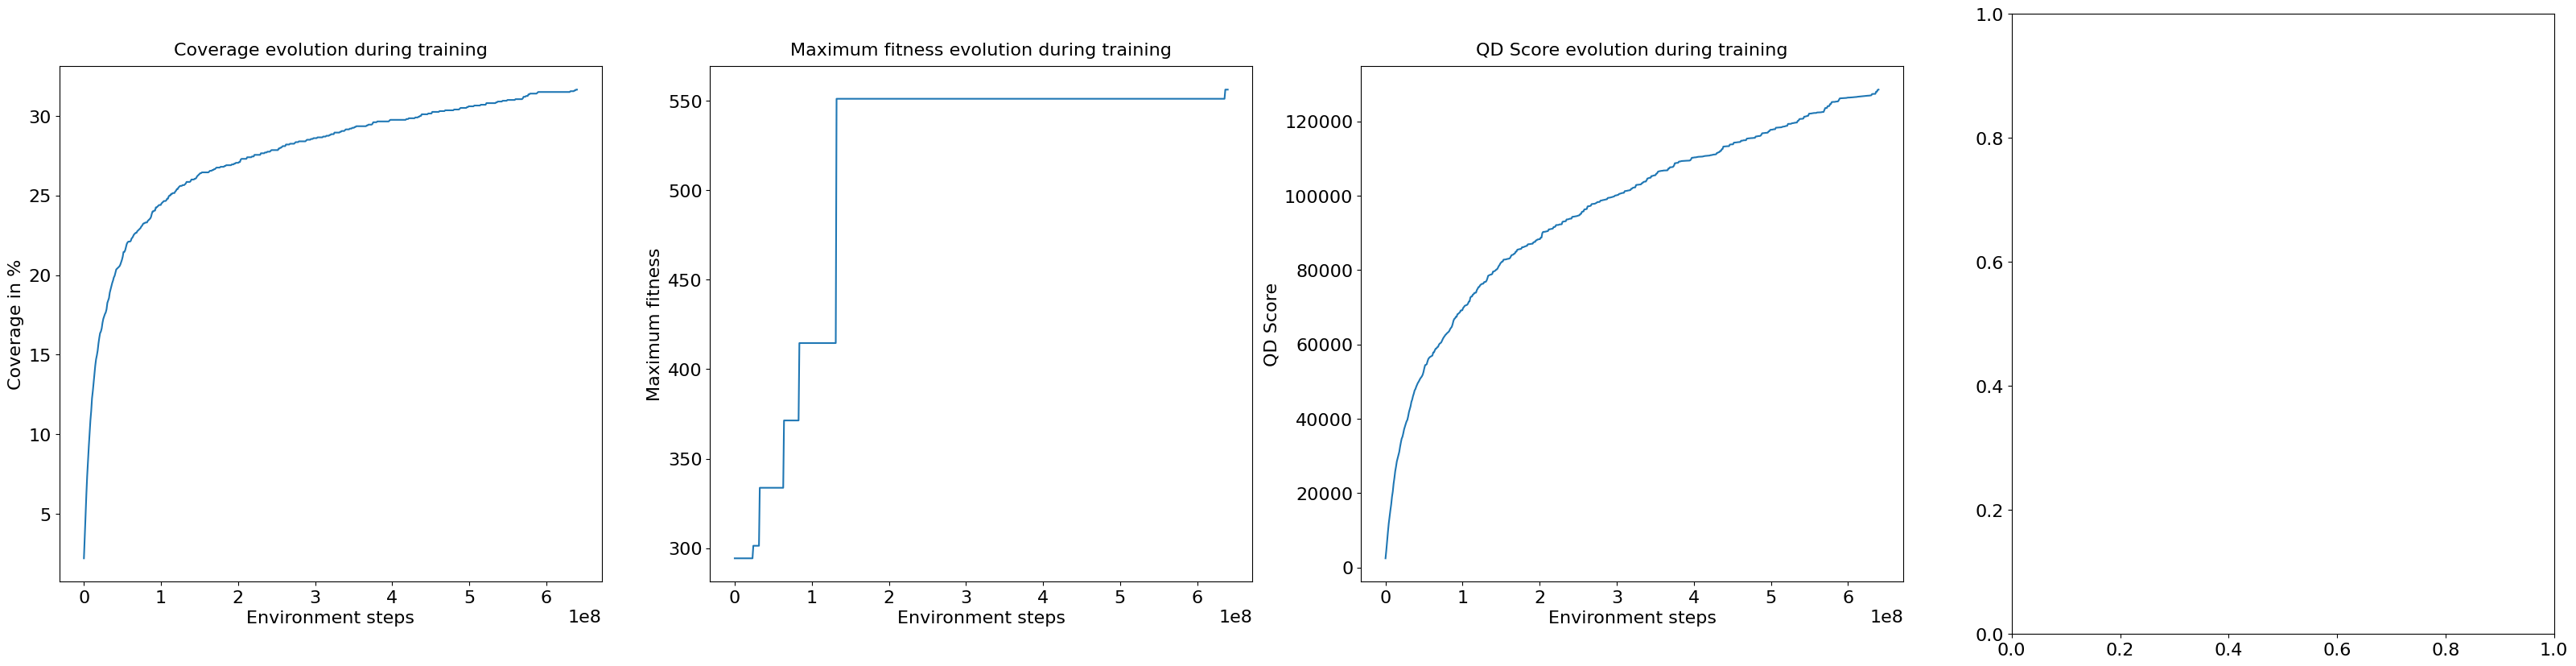

In [19]:
# Create the x-axis array
#env_steps = metrics["iteration"]
env_steps = metrics["iteration"] * batch_size * episode_length * config["NUM_ENVS"]
#print(jnp.max(metrics["iteration"]))

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

In [20]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 556.20
 Descriptor of the best individual in the repertoire: [0.09865317 0.7282071  0.3877519 ]
 Index in the repertoire of this individual: 998



In [24]:
# select the parameters of the best individual
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [23]:
# Set up environment
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy_network.apply)

def visualize_recurrent_policy(trained_params, config):
    rng = jax.random.PRNGKey(config["SEED"])
    key, key_r, key_a, key_p = jax.random.split(rng, 4)

    # reset env
    obs, state = env.reset(key_r)
    #obs, state = jit_env_reset(rng=key_r)
    print("Agents:", env.agents)

    # Create policy network
    policy_net = ActorRNN(
        action_dim=env.action_space(env.agents[0]).n,
        config=config
    )

    # Per-agent hidden states
    hidden_states = {
        agent: ScannedRNN.initialize_carry(1, config["GRU_HIDDEN_DIM"])  # batch_size = 1
        for agent in env.agents
    }
    dones = {agent: jnp.array(False) for agent in env.agents}
    returns = {agent: 0.0 for agent in env.agents}

    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        actions = {}
        avail_actions = env.get_avail_actions(state)

        for i, agent in enumerate(env.agents):
            # Add sequence and batch dims: (T=1, B=1, D)
            obs_agent = obs[agent][None, None, :]         # (T=1, B=1, obs_dim)
            done_agent = jnp.array(dones[agent])[None, None]  # (T=1, B=1)
            avail_agent = avail_actions[agent][None, None, :]  # (T=1, B=1, n_actions)
                    
            key, key_seq = jax.random.split(key)
            key_a = jax.random.split(key_seq, env.num_agents)[i]

            hidden = hidden_states[agent]
            hidden, pi = policy_net.apply(
                trained_params, hidden, (obs_agent, done_agent, avail_agent)
            )
            #hidden, pi = jit_inference_fn(trained_params, hidden, (obs_agent, done_agent, avail_agent))
            action = pi.sample(seed=key_a)

            actions[agent] = int(action.squeeze())  # turn into scalar
            hidden_states[agent] = hidden  # update per-agent hidden state

        key, key_s = jax.random.split(key)
        state_seq.append((key_s, state, actions))

        obs, state, rewards, dones, infos = env.step(key_s, state, actions)
        #obs, state, rewards, dones, infos = jit_env_step(key_s, state, action)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
    
        #print(f"Actions: {actions}")
        #print(f"The trajectory of this individual contains {len(state_seq)} transitions.")
        if step % 5 == 0:
            print(f"Current step: {step}")


        if dones["__all__"]:
            break

    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="MAP-Elites.gif")

Agents: ['ally_0', 'ally_1', 'ally_2', 'ally_3', 'ally_4']
Current step: 0
Current step: 5
Current step: 10
Current step: 15
Current step: 20
Current step: 25
Current step: 30
Current step: 35
Current step: 40
Current step: 45
Current step: 50
Current step: 55
Current step: 60
Current step: 65
Current step: 70
Current step: 75
Current step: 80
Current step: 85
Current step: 90
Returns: {'ally_0': Array(0.8812502, dtype=float32), 'ally_1': Array(0.8812502, dtype=float32), 'ally_2': Array(0.8812502, dtype=float32), 'ally_3': Array(0.8812502, dtype=float32), 'ally_4': Array(0.8812502, dtype=float32)}


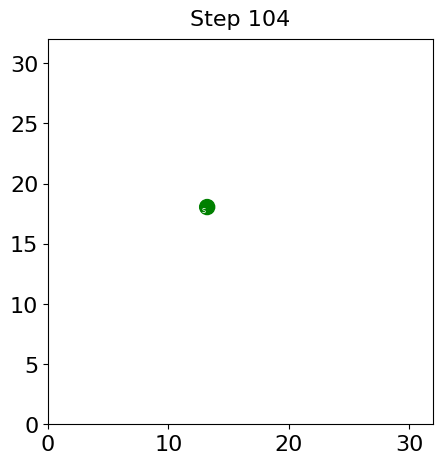

In [25]:
visualize_recurrent_policy(my_params, config)